In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
#Tải dữ liệu các nút và cạnh
with open("/content/drive/MyDrive/Nhóm 9_Graph Mining, Social Analysis/fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines()

with open("/content/drive/MyDrive/Nhóm 9_Graph Mining, Social Analysis/fb-pages-food.edges") as f:
    fb_links = f.read().splitlines()

len(fb_nodes), len(fb_links)

(621, 2102)

In [ ]:
# Tạo dataframe chứa tất cả các nút
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 445431.57it/s]


In [ ]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


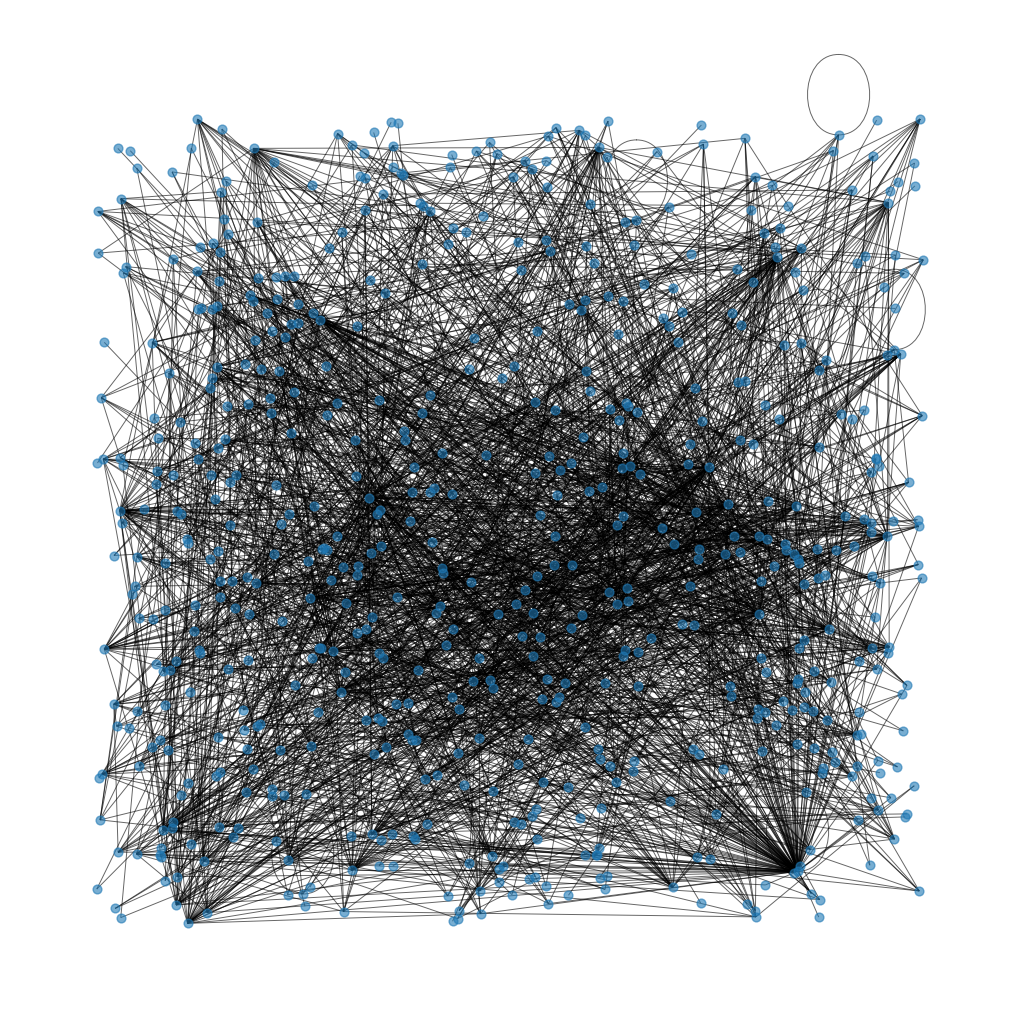

In [ ]:
# Tạo đồ thị
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [ ]:
# Gom tất cả các nút vào một danh sách
node_list = node_list_1 + node_list_2
# Loại bỏ các giá trị bị trùng
node_list = list(dict.fromkeys(node_list))
# Xây dựng ma trận kề
adj_G = nx.to_numpy_array(G, nodelist = node_list)

In [ ]:
adj_G.shape

(620, 620)

In [ ]:
print(np.array(adj_G))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Lấy ra các cặp nút không được kết nối
all_unconnected_pairs = []

# Duyệt qua ma trận
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:14<00:00, 42.05it/s] 


In [ ]:
# Đếm số lượng cặp nút không được kết nối
len(all_unconnected_pairs)

19018

In [ ]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked,
                     'node_2':node_2_unlinked})

# Thêm biến mục tiêu "link'
data['link'] = 0

In [ ]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# Tạo một danh sách trống để chứa các cặp nút có thể xóa
omissible_links_index = []

for i in tqdm(fb_df.index.values):

  # Xóa một cặp nút và tạo đồ thị mới
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())

  # Kiểm tra xem việc xóa một cặp nút có dẫn đến phân tách đồ thị hoặc giảm số lượng nút hay không
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:09<00:00, 231.76it/s]


In [ ]:
len(omissible_links_index)

1483

In [ ]:
# Tạo dataframe để chứa các cạnh có thể xóa
fb_df_ghost = fb_df.loc[omissible_links_index]

# Thêm biến mục tiêu 'link'
fb_df_ghost['link'] = 1

# Hợp nhất dữ liệu vào một dataframe
data = pd.concat([data, fb_df_ghost[['node_1', 'node_2', 'link']]], ignore_index=True)


In [ ]:
data['link'].value_counts()

,count
link,
0,19018


In [ ]:
# Xóa các cạnh có thể loại bỏ
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# Tạo đồ thị
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

In [ ]:
# Cài đặt thư viện node2vec
!pip install node2vec

In [ ]:
from node2vec import Node2Vec

node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:06<00:00,  7.28it/s]


In [ ]:
x = [(n2w_model.wv[str(i)]+n2w_model.wv[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'],
                                                test_size = 0.3,
                                                random_state = 35)

In [ ]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [ ]:
predictions = lr.predict_proba(xtest)

In [ ]:
roc_auc_score(ytest, predictions[:,1])

0.8301501983557084